# Task 3: 进阶上分方向

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ["WenQuanYi Micro Hei",'SimHei']
plt.rcParams['axes.unicode_minus'] = False

base_path=Path("data")
train_length=55392

In [2]:
electricity_price=pd.read_csv(base_path/"electricity_price_parsed.csv",parse_dates=["timestamp"],index_col=0)
electricity_price.columns=["demand","price"]
sample_submit=pd.read_csv(base_path/"sample_submit.csv")

train_data=electricity_price.copy(deep=True)  # 深拷贝原文件为独立的训练文件
electricity_price.head()

,demand,price
timestamp,,
2021-12-01 00:15:00,40334.18,350.80
2021-12-01 00:30:00,40523.15,350.80
2021-12-01 00:45:00,40374.74,350.80
2021-12-01 01:00:00,40111.55,350.80
2021-12-01 01:15:00,40067.50,348.93


## 1 时间序列法

首先，先根据Task2的讨论，进行特征提取，这个过程类似于计量的虚拟变量构建。

In [3]:
# 将电价数据的时间索引信息添加到训练数据中

# 提取时间索引的小时信息，并添加到训练数据中，创建 "hour" 列，内容为：0h,1h,...23h
train_data["hour"] = electricity_price.index.hour

# 提取时间索引的日期信息，并添加到训练数据中，创建 "day" 列
train_data["day"] = electricity_price.index.day

# 提取时间索引的月份信息，并添加到训练数据中，创建 "month" 列
train_data["month"] = electricity_price.index.month

# 提取时间索引的年份信息，并添加到训练数据中，创建 "year" 列
train_data["year"] = electricity_price.index.year

# 提取时间索引的星期信息，并添加到训练数据中，创建 "weekday" 列
train_data["weekday"] = electricity_price.index.weekday

# 根据月份信息，判断是否为风季（1-5月和9-12月），创建布尔型 "is_windy_season" 列
train_data["is_windy_season"] = electricity_price.index.month.isin([1, 2, 3, 4, 5, 9, 10, 11, 12])

# 根据小时信息，判断是否为低谷时段（10-15点），创建布尔型 "is_valley" 列
train_data["is_valley"] = electricity_price.index.hour.isin([10, 11, 12, 13, 14, 15])

# 提取时间索引的季度信息，并添加到训练数据中，创建 "quarter" 列
train_data["quarter"] = electricity_price.index.quarter

# 对时间特征进行独热编码（One-Hot Encoding），即把以上的内容全部转换成虚拟变量0/1，删除第一列以避免多重共线性
train_data = pd.get_dummies(
    data=train_data,        # 需要进行独热编码的 DataFrame
    columns=["hour", "day", "month", "year", "weekday"],  # 需要独热编码的列
    drop_first=True         # 删除第一列以避免多重共线性
)

train_data

,demand,price,is_windy_season,is_valley,quarter,hour_1,hour_2,hour_3,hour_4,hour_5,...,month_12,year_2022,year_2023,year_2024,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:15:00,40334.18,350.80,True,False,4,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2021-12-01 00:30:00,40523.15,350.80,True,False,4,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2021-12-01 00:45:00,40374.74,350.80,True,False,4,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2021-12-01 01:00:00,40111.55,350.80,True,False,4,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2021-12-01 01:15:00,40067.50,348.93,True,False,4,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18 23:00:00,35861.48,NaN,True,False,2,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
2024-04-18 23:15:00,35862.24,NaN,True,False,2,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
2024-04-18 23:30:00,35005.55,NaN,True,False,2,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False


In [4]:
# 构造节假日虚拟变量，这里个人在官方代码的基础上增加国庆节假期

def generate_holiday_dates(start_dates, duration):
    holidays = []  # 初始化一个空列表，用于存储节假日日期
    for start_date in start_dates:  # 遍历每个节假日的开始日期
        # 生成从 start_date 开始的日期范围，持续时间为 duration 天
        holidays.extend(pd.date_range(start=start_date, periods=duration).tolist())
    return holidays  # 返回所有节假日日期的列表

spring_festival_start_dates = ["2022-01-31", "2023-01-21", "2024-02-10"]
labor_start_dates = ["2022-04-30", "2023-04-29"]
national_start_dates = ['2022-10-01', '2023-10-01']
spring_festivals = generate_holiday_dates(spring_festival_start_dates, 7)
labor = generate_holiday_dates(labor_start_dates, 5)
national = generate_holiday_dates(national_start_dates, 7)

# 判断训练数据的索引是否在春节日期列表中，生成布尔型列 "is_spring_festival"
train_data["is_spring_festival"] = train_data.index.isin(spring_festivals)

# 判断训练数据的索引是否在劳动节日期列表中，生成布尔型列 "is_labor"
train_data["is_labor"] = train_data.index.isin(labor)

# 判断训练数据的索引是否在国庆节节日期列表中，生成布尔型列 "is_national"
train_data["is_national"] = train_data.index.isin(national)

train_data

,demand,price,is_windy_season,is_valley,quarter,hour_1,hour_2,hour_3,hour_4,hour_5,...,year_2024,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,is_spring_festival,is_labor,is_national
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:15:00,40334.18,350.80,True,False,4,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2021-12-01 00:30:00,40523.15,350.80,True,False,4,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2021-12-01 00:45:00,40374.74,350.80,True,False,4,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2021-12-01 01:00:00,40111.55,350.80,True,False,4,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2021-12-01 01:15:00,40067.50,348.93,True,False,4,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18 23:00:00,35861.48,NaN,True,False,2,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
2024-04-18 23:15:00,35862.24,NaN,True,False,2,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
2024-04-18 23:30:00,35005.55,NaN,True,False,2,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False


此外，可以发现一段时间内，总负荷如果有下降趋势，则下一个出清价格也可能下降。因此联想到构造基于总需求的窗口特征。所以我们还可以用滑动窗口构造特征：

滑动窗口特征，即以滑动窗口为大小，滚动求统计特征。

In [5]:
def cal_range(x): # 极差
    return x.max() - x.min()


def increase_num(x): # 发生增长的次数
    return (x.diff() > 0).sum() 
# x.diff() = xt - xt-1


def decrease_num(x): # 发生下降的次数
    return (x.diff() < 0).sum()


def increase_mean(x): # 上升序列均值
    diff = x.diff()
    return diff[diff > 0].mean()


def decrease_mean(x): # 下降序列均值
    diff = x.diff()
    return diff[diff < 0].abs().mean()


def increase_std(x): # 上升序列标准差
    diff = x.diff()
    return diff[diff > 0].std()


def decrease_std(x): # 下降序列标准差
    diff = x.diff()
    return diff[diff < 0].std()


In [6]:
from tqdm import tqdm  # 导入 tqdm 库用于显示进度条

# 这里定义了3个不同的滚动窗口大小，分别是4、12和24。
window_sizes = [4, 12, 24]

# 遍历每个窗口大小
with tqdm(window_sizes) as pbar:
    for window_size in pbar:
        # 定义要应用的聚合函数列表
        functions = ["mean", "std", "min", "max", cal_range, increase_num,
                     decrease_num, increase_mean, decrease_mean, increase_std, decrease_std]

        # 遍历每个聚合函数
        for func in functions:
            # 获取函数名称，如果是字符串则直接使用，否则使用函数的 __name__ 属性
            func_name = func if type(func) == str else func.__name__

            # 生成新列名，格式为 demand_rolling_{window_size}_{func_name}
            column_name = f"demand_rolling_{window_size}_{func_name}"

            # 计算滚动窗口的聚合值，并将结果添加到 train_data 中
            train_data[column_name] = train_data["demand"].rolling(
                window=window_size,        # 滚动窗口大小
                min_periods=window_size//2,  # 最小观测值数
                closed="left"         # 滚动窗口在左侧闭合
            ).agg(func)              # 应用聚合函数

            pbar.set_postfix({"window_size": window_size, "func": func_name})

# 跑了7分钟。。

100%|██████████| 3/3 [07:01<00:00, 140.34s/it, window_size=24, func=decrease_std] 


In [7]:
train_data

,demand,price,is_windy_season,is_valley,quarter,hour_1,hour_2,hour_3,hour_4,hour_5,...,demand_rolling_24_std,demand_rolling_24_min,demand_rolling_24_max,demand_rolling_24_cal_range,demand_rolling_24_increase_num,demand_rolling_24_decrease_num,demand_rolling_24_increase_mean,demand_rolling_24_decrease_mean,demand_rolling_24_increase_std,demand_rolling_24_decrease_std
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:15:00,40334.18,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01 00:30:00,40523.15,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01 00:45:00,40374.74,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01 01:00:00,40111.55,350.80,True,False,4,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01 01:15:00,40067.50,348.93,True,False,4,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18 23:00:00,35861.48,NaN,True,False,2,False,False,False,False,False,...,2140.395876,30142.07,38779.19,8637.12,14.0,9.0,774.950714,630.898889,673.068468,285.044511
2024-04-18 23:15:00,35862.24,NaN,True,False,2,False,False,False,False,False,...,1742.113095,31891.42,38779.19,6887.77,14.0,9.0,689.153571,630.898889,613.200022,285.044511
2024-04-18 23:30:00,35005.55,NaN,True,False,2,False,False,False,False,False,...,1481.155426,33507.06,38779.19,5272.13,14.0,9.0,573.805000,630.898889,576.289189,285.044511


此外，还可以加入经典计量学的特征，如滞后、差分等

In [8]:
# 一阶滞后
train_data["demand_shift_1"] = train_data["demand"].shift(1)

# 一阶差分
train_data["demand_diff_1"] = train_data["demand"].diff(1)

# 算术增长率
train_data["demand_pct_1"] = train_data["demand"].pct_change(1)

In [9]:
train_data

,demand,price,is_windy_season,is_valley,quarter,hour_1,hour_2,hour_3,hour_4,hour_5,...,demand_rolling_24_cal_range,demand_rolling_24_increase_num,demand_rolling_24_decrease_num,demand_rolling_24_increase_mean,demand_rolling_24_decrease_mean,demand_rolling_24_increase_std,demand_rolling_24_decrease_std,demand_shift_1,demand_diff_1,demand_pct_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:15:00,40334.18,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01 00:30:00,40523.15,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40334.18,188.97,0.004685
2021-12-01 00:45:00,40374.74,350.80,True,False,4,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40523.15,-148.41,-0.003662
2021-12-01 01:00:00,40111.55,350.80,True,False,4,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40374.74,-263.19,-0.006519
2021-12-01 01:15:00,40067.50,348.93,True,False,4,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40111.55,-44.05,-0.001098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-18 23:00:00,35861.48,NaN,True,False,2,False,False,False,False,False,...,8637.12,14.0,9.0,774.950714,630.898889,673.068468,285.044511,35313.29,548.19,0.015524
2024-04-18 23:15:00,35862.24,NaN,True,False,2,False,False,False,False,False,...,6887.77,14.0,9.0,689.153571,630.898889,613.200022,285.044511,35861.48,0.76,0.000021
2024-04-18 23:30:00,35005.55,NaN,True,False,2,False,False,False,False,False,...,5272.13,14.0,9.0,573.805000,630.898889,576.289189,285.044511,35862.24,-856.69,-0.023888


In [10]:
# 填充因为滞后、差分等形成的NaN：

# 从 train_data 中创建训练集和测试集特征数据 (X) 和目标数据 (y)

# 创建训练集特征数据 X_train
# 1. 从 train_data 中选择前 train_length 行，去除 "price" 列
# 2. 使用 bfill 方法向后填充缺失值
# 3. 使用 ffill 方法向前填充缺失值
X_train = train_data.iloc[:train_length].drop(columns=["price"]).bfill().ffill()

# 创建测试集特征数据 X_test
X_test = train_data.iloc[train_length:].drop(columns=["price"]).bfill().ffill()

# 创建训练集目标数据 y_train
y_train = train_data.iloc[:train_length][["price"]]

bfill()：向后填充（backward fill），即用后一个有效值填充当前的 NaN。
ffill()：向前填充（forward fill），即用前一个有效值填充当前的 NaN。

模型回归：

In [11]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# 创建 LGBMRegressor 模型对象，设置参数
# num_leaves：树的叶子数，控制模型复杂度
# n_estimators：迭代次数，即树的数量
# verbose：日志信息级别，-1 表示不输出日志信息
lgb_model = LGBMRegressor(num_leaves=2**5-1, n_estimators=300, verbose=-1)

# 创建线性回归模型对象
linear_model = LinearRegression()

# 使用训练集数据训练 LGBMRegressor 模型
# X_train：训练集特征数据
# y_train：训练集目标数据
lgb_model.fit(X_train, y_train)

# 使用训练集数据中的 "demand" 特征训练线性回归模型
# X_train[["demand"]]：训练集特征数据中仅包含 "demand" 列
# y_train：训练集目标数据
linear_model.fit(X_train[["demand"]], y_train)

# 使用训练好的 LGBMRegressor 模型预测测试集特征数据
# X_test：测试集特征数据
# 返回预测的目标值
lgb_pred = lgb_model.predict(X_test)

# 使用训练好的线性回归模型预测测试集特征数据中的 "demand" 列
# X_test[["demand"]]：测试集特征数据中仅包含 "demand" 列
# 返回预测的目标值，并将结果展平为一维数组
linear_pred = linear_model.predict(X_test[["demand"]]).flatten()

In [12]:
# 最后的修正：
# 简单求均值
y_pred = (lgb_pred+linear_pred)/2
y_pred *= 0.95  # 进行少量修正

In [13]:
# 保存
sample_submit["clearing price (CNY/MWh)"] = y_pred
sample_submit.to_csv("submit.csv", index=False)
sample_submit.head()

,day,time,clearing price (CNY/MWh)
0,2023/7/1,0:15,391.704814
1,2023/7/1,0:30,386.056237
2,2023/7/1,0:45,379.044964
3,2023/7/1,1:00,376.880418
4,2023/7/1,1:15,382.486849


## 2 ABM报价策略优化

在Task1中，采用的是“边际成本”来作为自己的报价。但是，agent可以进行的报价操作远比这个复杂。

### 2.1 报价策略优化

Baseline1中我们假定了智能体的报价只有一个值，但思考这样一个场景，假如某机组最大出力是600MW，都报350元，而市场以345元出清了，机组因为5元之差没能中标，损失了全部电力。

而现在这个机组学聪明了，为了降低风险，他选择前300MW出力报300元，后300W出力报400元，这样即使最终价格在300-400之间，他保底能卖出300MW的出力。

这就是现实中的机组报价方式：分段报价。可以类比股票中的金字塔加仓策略，机组不会把所有出力都报一样的价格，而是随着出力升高报更高的价格

### 2.2 报价策略

在Baseline1中，机组总是以边际成本（即边际煤耗）报价，即

$$P = MC = kP_{\text{coal}}N_{\text{coal}}$$

- **k**: 能量利用率，即unit数据信中的power consumption rate (%)
- **$P_{\text{coal}}$**: 单位标准煤价，需要利用外部数据获取
- **$N_{\text{coal}}$**: 边际煤耗量，即数据信中的coal consumption (g coal/KWh)

而实际上机组报价会随负荷变动：

- 当负荷较低（对应数据的10-15时的低谷区）和光伏发电占优的时候，机组降低报价，避免电力无法中标。
- 当负荷较高（对应数据的早晚高峰）和光伏发电较低（阴雨天）时，机组提高报价，争取获得更多的利益

因此最终优化后的报价函数应乘以机组在时的策略报价系数$$k_t$$，其受自身参数、市场供需、其他机组策略、总负荷决定：

$$P_t = k_t \times MC$$

我们可以从赛方数据中总负荷和出清价格的关系中观察到这一特性：总负荷时，大多数机组都倾向于边际成本报价，价格较为稳定。而在高负荷的时候，机组盈利意愿提高，倾向于冒更大风险报价，从而价格弹性较高。

![kt](./kt.png)

### 2.3 其他可以参考的优化报价策略

- 预测竞争机组的策略，决定自身的报价方式：例如根据其他机组的成本，得到整体的报价曲线，并以此决定自己的报价。但在实际中，机组无法获知全部的其他机组信息
- 基于博弈论模型，例如古诺模型（Cournot），寡头市场中的斯塔克伯格模型（Stackelberg）
- ...

## 3 强化学习

强化学习的几个要素包括状态、动作、奖励和策略。其中，对于这个题目而言，状态空间连续，动作主要是出价的方式。这里想要训练一个好的强化学习模型，更重要的是设计好的奖励函数和策略，使得每一次训练的出价策略能够有恰到好处的收益。这需要一定的实践经验。

在一个强化学习环境里面，智能体的目的就是选取一系列的动作来最大化奖励，所以这些选取的动作必须有长期的影响。也就是说，智能体在决策中的每一步累计起来，最后形成了交易中的好结果与坏结果，这是个序列决策。整个决策的状态本质上是一个关于其历史的函数。

### demo示例

首先，进行环境初始化：

In [14]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from typing import Union
import gymnasium as gym

In [15]:
# 使用openai的库轻松构建环境
env = gym.make("CartPole-v1")
# CartPole-v1 是一个经典的强化学习环境，其中目标是通过移动推车来保持竖直的杆子平衡
env.reset()
env.step(1)
# 这段代码创建了一个 CartPole-v1 环境，重置了该环境，并执行了一个动作（动作编号为 1），从而推进了环境的状态。

(array([ 0.04556271,  0.17771758,  0.01427857, -0.24963732], dtype=float32),
 1.0,
 False,
 False,
 {})

In [16]:
env.observation_space.high[2]
# 在 CartPole-v1 环境中，观测空间是一个多维向量，包含描述系统状态的多个变量，例如推车的位置、速度、杆子的角度等
# env.observation_space.high 返回一个包含观测空间中每个变量最大值的数组。换句话说，这个数组中的每个元素表示该维度观测值的上限
#  env.observation_space.high[2] 是从上面的数组中获取第三个变量的最大值。在 CartPole-v1 环境中，第三个变量通常是杆子的角速度（angular velocity）的上限值。

0.41887903

接下来，使用神经网络进行模型训练，这里构建了一个Q网络。该网络是为了在强化学习中实现 Q-learning，其中 Q 网络用于估计给定状态下每个可能动作的 Q 值

In [17]:
class QNet(nn.Module):
    """
    QNet: 将离散状态集映射到动作集，最后输出值可正可负的。
    """

    def __init__(self, dim_state, num_action):
        super().__init__()
        self.fc1 = nn.Linear(dim_state, 64)  # 第一层全连接层，将状态维度映射到64维
        self.fc2 = nn.Linear(64, 32)         # 第二层全连接层，将64维映射到32维
        self.fc3 = nn.Linear(32, num_action) # 输出层，将32维映射到动作空间

    def forward(self, state):
        # state shape (32,4) 32为batch 4为feature_size
        x = F.relu(self.fc1(state))  # 使用ReLU激活函数
        x = F.relu(self.fc2(x))      # 使用ReLU激活函数
        x = self.fc3(x)              # 输出层没有激活函数，直接输出Q值
        return x
    

net=QNet(4,2)

state=torch.randn(32,4)
net(state).shape

torch.Size([32, 2])

然后，我们定义了一个简单的经验回放缓冲区 (ReplayBuffer)，这是强化学习中特别是在深度 Q 学习 (DQN) 中常用的一个组件。它用于存储智能体与环境交互的经验样本，并在训练时随机采样这些经验，以打破数据的相关性，从而提高训练的稳定性和效率。

In [23]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.storage = []
        self.buffer_size = buffer_size
        self.index = 0

    def push(self, state: Union[np.ndarray, int], action: Union[np.ndarray, int], reward: float, next_state: Union[np.ndarray, int], done: bool) -> None:
        data = (state, action, reward, next_state, done)
        # 当缓冲池不到上限时，index和池大小是一致的。一旦到达上限，index将从头开始计数，并不断替代旧经验，以此循环
        # 因此到达上限后，只能不断执行else语句
        if self.index >= len(self.storage):
            self.storage.append(data)
        else:
            self.storage[self.index] = data
        self.index = (self.index+1) % self.buffer_size

    def sample(self, size: int):
        """
        :param size:采样的数量
        """
        indices = np.random.choice(len(self.storage), size=size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            state, action, reward, next_state, done = self.storage[i]
            states.append(np.array(state))
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (
            np.stack(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.stack(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.storage)


buffer = ReplayBuffer(3)

for _ in range(3):
    buffer.push(np.array([3, 9]), 2, 3, np.array([9, 10]), False)
print(buffer.storage)

# 测试用例
state = np.array([1, 2])
action = 1
reward = 7
next_state = np.array([2, 3])
done = True

buffer.push(state, action, reward, next_state, done)
print(buffer.storage)

[(array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False)]
[(array([1, 2]), 1, 7, array([2, 3]), True), (array([3, 9]), 2, 3, array([ 9, 10]), False), (array([3, 9]), 2, 3, array([ 9, 10]), False)]


In [24]:
buffer.sample(2) # 从 ReplayBuffer 中随机采样 2 个经验样本

(array([[3., 9.],
        [3., 9.]], dtype=float32),
 array([2, 2], dtype=int64),
 array([3., 3.], dtype=float32),
 array([[ 9., 10.],
        [ 9., 10.]], dtype=float32),
 array([0., 0.], dtype=float32))

此外，我们还使用了一个深度 Q 网络（DQN）类，用于强化学习中的 Q-learning 算法。DQN 是一种将深度学习与 Q-learning 相结合的算法，利用神经网络来估计 Q 值（即在给定状态下执行特定动作的预期回报）。

In [25]:
class DQN:
    def __init__(self, dim_state, num_action, gamma=0.9, device="cpu") -> None:
        self.gamma = gamma  # 折扣因子
        self.Q = QNet(dim_state, num_action).to(device)
        self.target_Q = QNet(dim_state, num_action).to(device)
        self.target_Q.load_state_dict(self.Q.state_dict())
        self.device = device

    def get_action(self, state: np.ndarray):
        # state: (batch_size,dim_state)
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q_pred = self.Q(state)
        # 获取Q值最大的动作，即找每一行的最大值位置
        return q_pred.argmax(1)  # (batch_size,)

    def compute_loss(self, b_state, b_action, b_reward, b_next_state, b_done):
        """计算TD损失，MSE_LOSS"""
        q_pred = self.Q(b_state).gather(1, b_action.unsqueeze(1)).squeeze(
            1)  # [batch_size,action_space]->[batch_size,1]->[batch_size]
        # 需要找当前状态，对应动作的Q值
        q_pred_next, _ = self.target_Q(b_next_state).detach().max(dim=1)  # 目标值算做固定值，不参与反向传播
        loss = F.mse_loss(q_pred, b_reward+self.gamma*q_pred_next*(1-b_done))
        return loss

    def update_target_Q(self):
        """定期把主Q网络的权重复制到目标Q网络中"""
        self.target_Q.load_state_dict(self.Q.state_dict())

开始训练模型：

In [26]:
loss_list = []
reward_list = []

epsilon = 1.0
warm_up_steps = 1000
max_reward = 0
state, _ = env.reset()
episode_reward = 0
batch_size = 32
max_steps = 10000
device = "cuda"
buffer = ReplayBuffer(1000)
dqn = DQN(4, 2, device=device)
optimizer = torch.optim.Adam(dqn.Q.parameters(), lr=0.001)

for i in range(max_steps):
    if random.random() < epsilon or i < warm_up_steps:  # 随机探索
        action = env.action_space.sample()
    else:
        # 贪婪策略
        action = dqn.get_action(state).item()

    # 用新动作迭代，获得下个状态和当前奖励
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    episode_reward += reward
    # 放入经验池
    buffer.push(state, action, reward, next_state, done)
    # 更新状态
    state = next_state

    if done:
        state, _ = env.reset()
        reward_list.append(episode_reward)

        if episode_reward > max_reward:
            max_reward = episode_reward
            torch.save(dqn.Q.state_dict(), "dqn.bin")
        episode_reward = 0
        epsilon = 1.0 - 0.9 * (i-warm_up_steps) / (max_steps-warm_up_steps)  # 更新探索值，会越来越接近贪婪解

    if i >= warm_up_steps:
        """积累一定经验，开始更新参数"""
        transition = buffer.sample(batch_size)  # 缓冲区采样
        transition = [torch.as_tensor(array, device=device) for array in transition]
        optimizer.zero_grad()
        loss = dqn.compute_loss(*transition)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if i % 50 == 0:
            # 定期更新目标网络参数
            dqn.update_target_Q()
        if (i+1) % 1000 == 0:
            print({"step": i+1, "loss": f"{loss.item():.3f}", "epsilon": f"{epsilon:.3f}", "max_reward": max_reward})

{'step': 2000, 'loss': '0.478', 'epsilon': '0.901', 'max_reward': 86.0}
{'step': 3000, 'loss': '0.079', 'epsilon': '0.802', 'max_reward': 103.0}
{'step': 4000, 'loss': '0.148', 'epsilon': '0.701', 'max_reward': 103.0}
{'step': 5000, 'loss': '0.042', 'epsilon': '0.611', 'max_reward': 158.0}
{'step': 6000, 'loss': '1.175', 'epsilon': '0.516', 'max_reward': 179.0}
{'step': 7000, 'loss': '0.031', 'epsilon': '0.411', 'max_reward': 179.0}
{'step': 8000, 'loss': '0.228', 'epsilon': '0.310', 'max_reward': 179.0}
{'step': 9000, 'loss': '0.996', 'epsilon': '0.210', 'max_reward': 179.0}
{'step': 10000, 'loss': '0.023', 'epsilon': '0.104', 'max_reward': 179.0}


来可视化结果：

Text(0.5, 1.0, 'Reward')

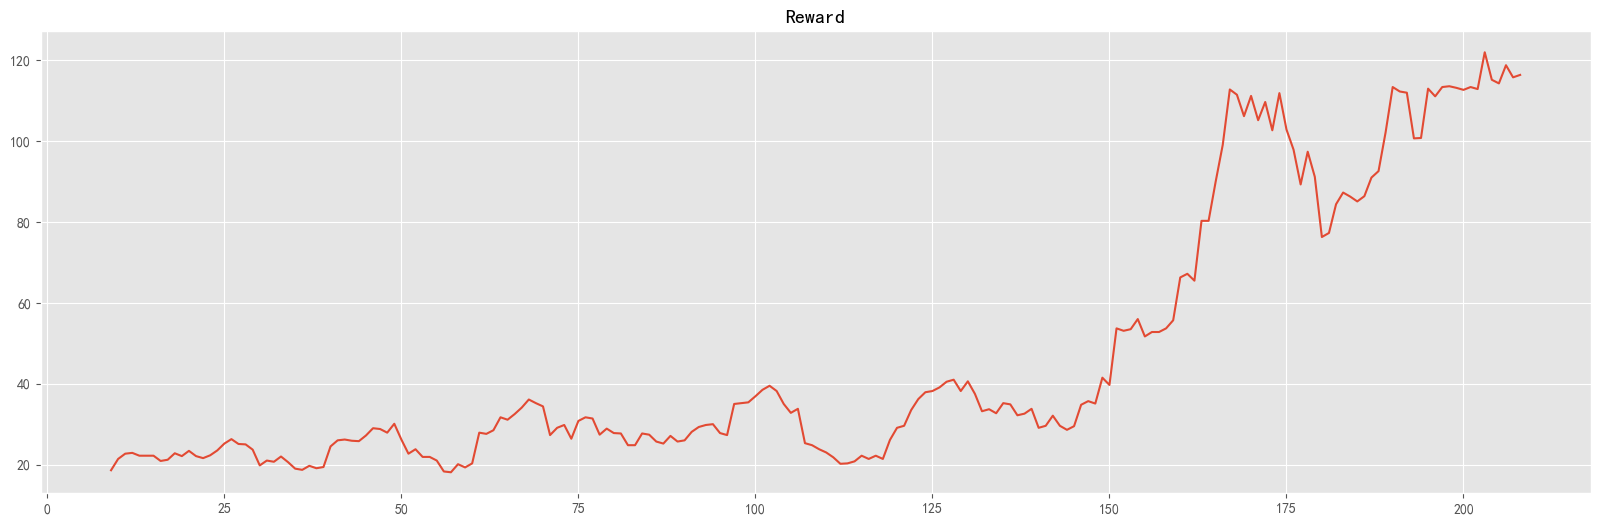

In [27]:
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.lineplot(pd.Series(reward_list).rolling(10).mean())
plt.title("Reward")

Text(0.5, 1.0, 'loss')

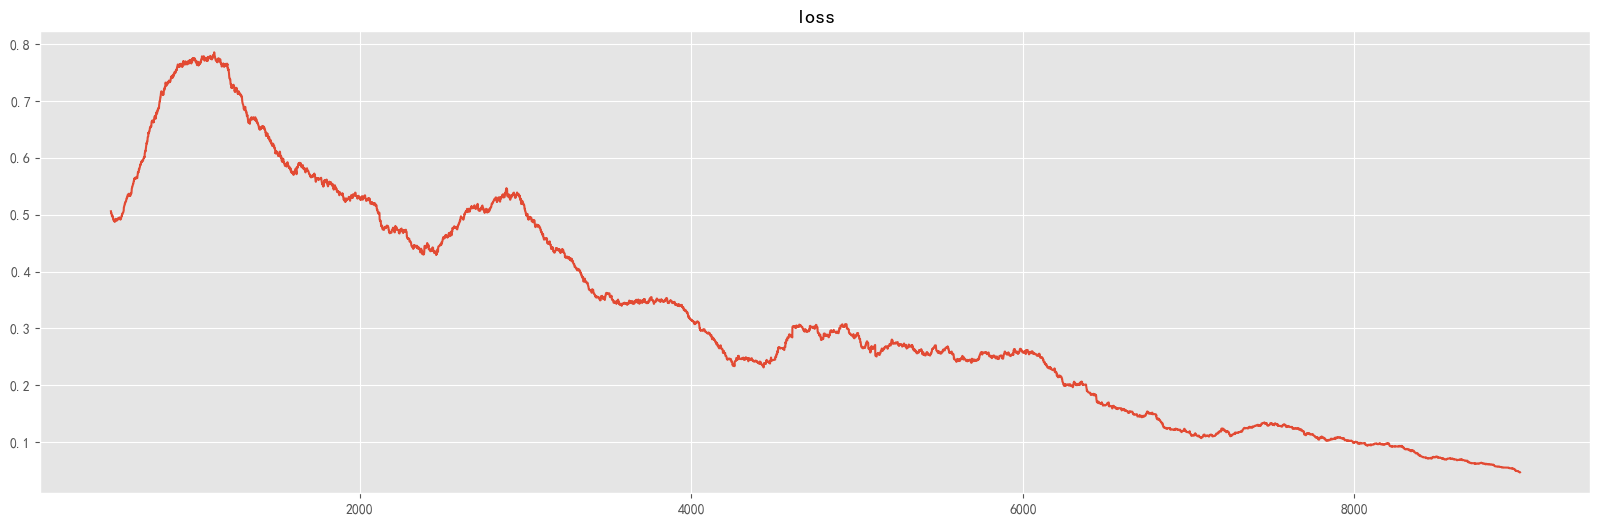

In [28]:
import seaborn as sns
plt.figure(figsize=(20, 6))
sns.lineplot(pd.Series(loss_list).rolling(500).mean())
plt.title("loss")

训练完毕后保存模型

In [30]:
torch.save(dqn.Q,"./models/model.bin")

之后还可以读取保存的模型：

In [31]:
import gymnasium as gym
env = gym.make("CartPole-v1")
env.reset() # 先重置环境

(array([-0.00308453,  0.02950272, -0.01704014,  0.0138693 ], dtype=float32),
 {})

In [32]:
net=torch.load("models/model.bin",weights_only=False)
net

QNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

运行强化学习智能体并实时显示其在 CartPole-v1 环境中的表现

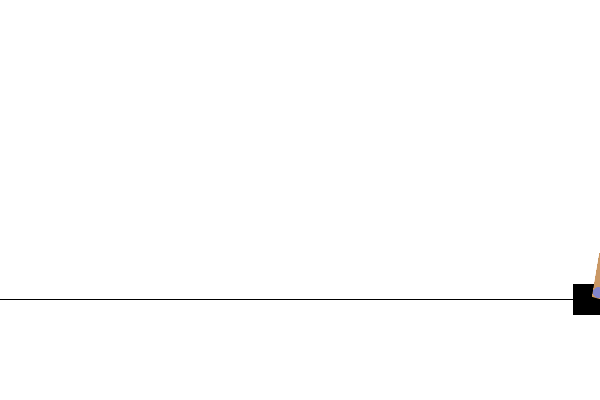

Finished! 最大轮次为： 108


In [34]:
import matplotlib.pylab as plt
from PIL import Image
from IPython.display import display, clear_output
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
for step in range(1000):
    clear_output(wait=True)
    display(Image.fromarray(env.render()))
    state = torch.as_tensor(state, device="cuda").unsqueeze(0)
    action = net(state).argmax(1).item()
    # action=env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print(f"Finished! 最大轮次为：", step)
        break


env.close()